# Projeto de Inteligência Artificial

**Tema:** Mental Health Data

**Objetivo:** Aplicar técnicas de Supervised Learning para prever casos de depressão.

In [2]:
# Instalar as dependências, se necessário
%pip install pandas numpy matplotlib seaborn scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc


## 1. Carregamento dos Dados

In [4]:
df = pd.read_csv("data/train.csv")
df.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


## 2. Verificações Iniciais

In [5]:
# Definir colunas
numeric_cols = ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA',
                'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Financial Stress']

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col != 'Depression']

# Imputação
numeric_imputer = SimpleImputer(strategy='median')
df[numeric_cols] = numeric_imputer.fit_transform(df[numeric_cols])

categorical_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])

# Verificar missing values
df.isnull().sum().sum()

np.int64(0)

## 3.Análise Exploratória (EDA)

Informação geral do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             140700 non-null  object 
 7   Academic Pressure                      140700 non-null  float64
 8   Work Pressure                          140700 non-null  float64
 9   CGPA                                   140700 non-null  float64
 10  Study Satisfaction         

/tmp/ipykernel_23201/2581469080.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Depression', data=df, palette='Set2')


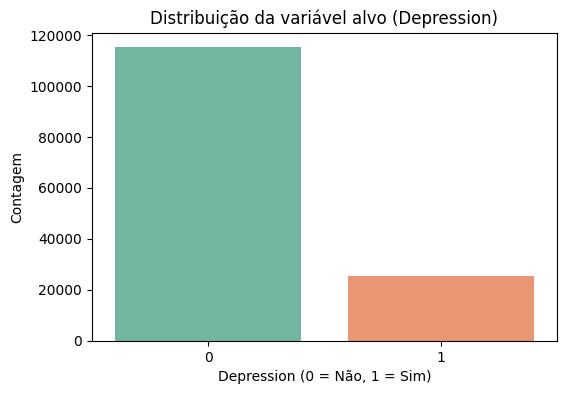

/tmp/ipykernel_23201/2581469080.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Gender', data=df, palette='Set3')


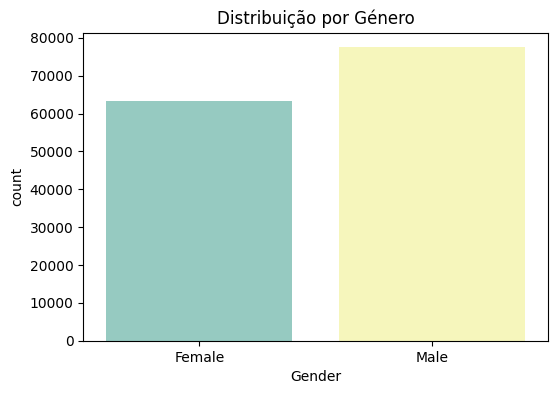

/tmp/ipykernel_23201/2581469080.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cities.index, y=top_cities.values, palette='viridis')


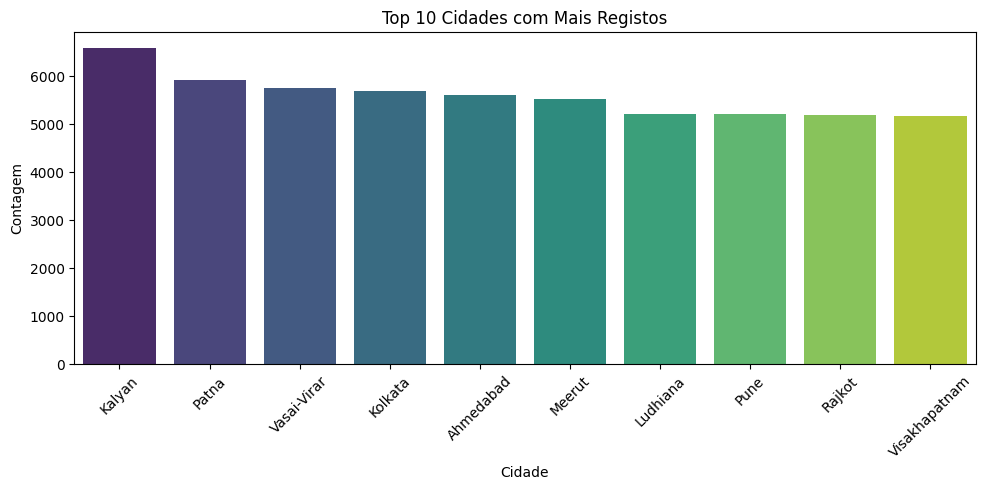

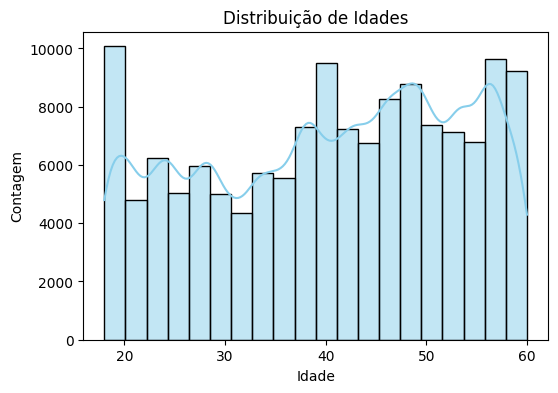

/tmp/ipykernel_23201/2581469080.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Depression', y=col, data=df, palette='coolwarm')


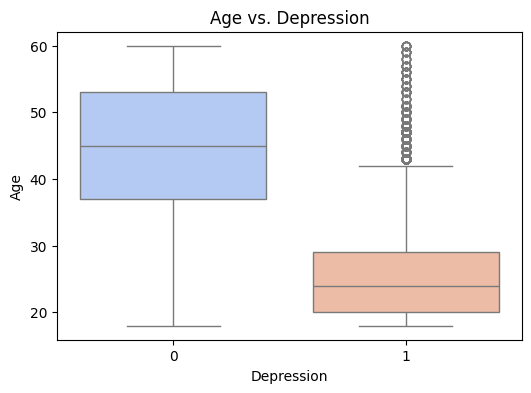

/tmp/ipykernel_23201/2581469080.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Depression', y=col, data=df, palette='coolwarm')


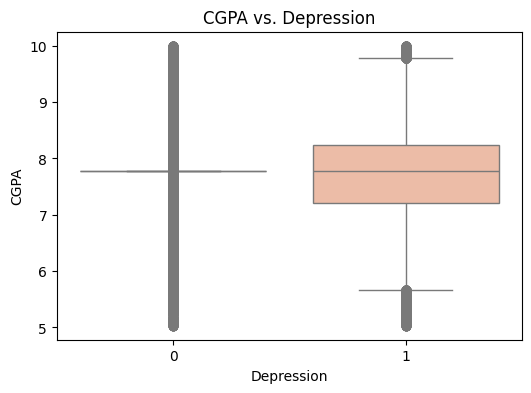

/tmp/ipykernel_23201/2581469080.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Depression', y=col, data=df, palette='coolwarm')


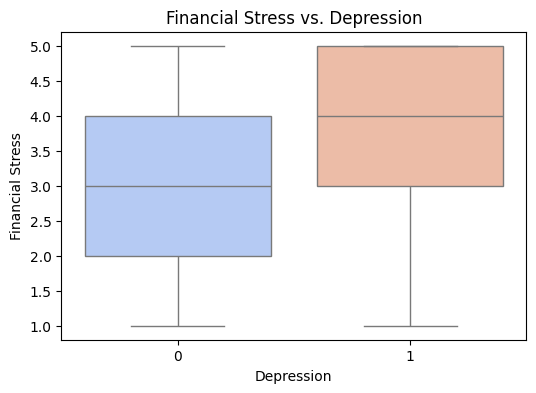

/tmp/ipykernel_23201/2581469080.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Depression', y=col, data=df, palette='coolwarm')


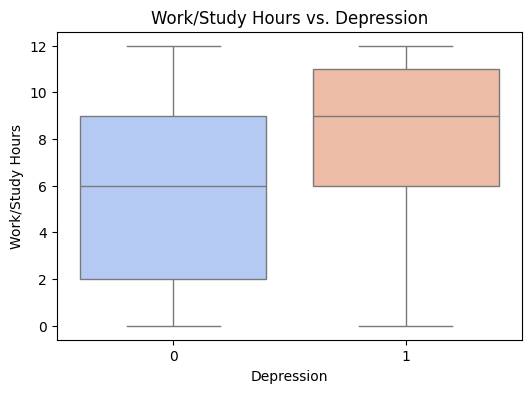

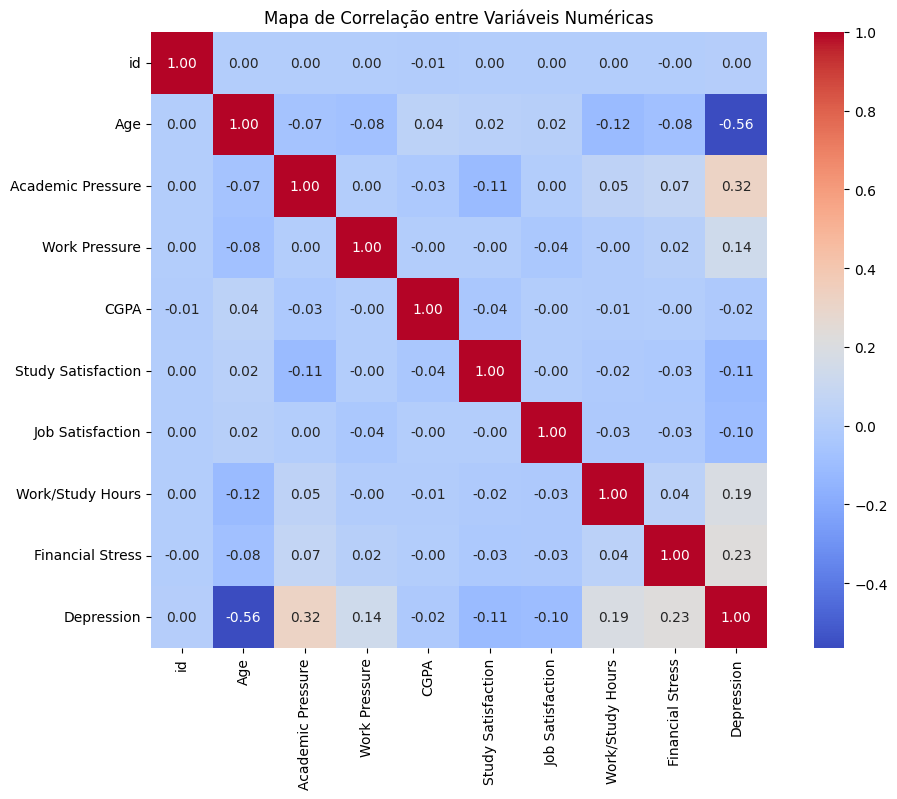

In [9]:
# Verificar estrutura do DataFrame
print("Informação geral do dataset:")
df.info()

# Sumário estatístico das colunas numéricas
print("\nSumário estatístico:")
print(df.describe())

# Verificar valores nulos
print("\nMissing values por coluna:")
print(df.isnull().sum())

# Distribuição da variável target (Depression)
plt.figure(figsize=(6, 4))
sns.countplot(x='Depression', data=df, palette='Set2')
plt.title("Distribuição da variável alvo (Depression)")
plt.xlabel("Depression (0 = Não, 1 = Sim)")
plt.ylabel("Contagem")
plt.show()

# Distribuição por género
plt.figure(figsize=(6, 4))
sns.countplot(x='Gender', data=df, palette='Set3')
plt.title("Distribuição por Género")
plt.show()

# Top 10 cidades com mais entradas
plt.figure(figsize=(10, 5))
top_cities = df['City'].value_counts().nlargest(10)
sns.barplot(x=top_cities.index, y=top_cities.values, palette='viridis')
plt.title("Top 10 Cidades com Mais Registos")
plt.ylabel("Contagem")
plt.xlabel("Cidade")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Histograma das idades
plt.figure(figsize=(6, 4))
sns.histplot(df['Age'], kde=True, bins=20, color='skyblue')
plt.title("Distribuição de Idades")
plt.xlabel("Idade")
plt.ylabel("Contagem")
plt.show()

# Boxplots para algumas variáveis numéricas vs. Depression
numeric_to_plot = ['Age', 'CGPA', 'Financial Stress', 'Work/Study Hours']

for col in numeric_to_plot:
    if col in df.columns:
        plt.figure(figsize=(6, 4))
        sns.boxplot(x='Depression', y=col, data=df, palette='coolwarm')
        plt.title(f"{col} vs. Depression")
        plt.show()

# Heatmap de correlação (só variáveis numéricas)
plt.figure(figsize=(12, 8))
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
corr = df[numeric_cols].corr()

sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Mapa de Correlação entre Variáveis Numéricas")
plt.show()

In [ ]:
categorical_cols = [
    'Gender', 'City', 'Working Professional or Student', 'Profession',
    'Sleep Duration', 'Dietary Habits', 'Degree',
    'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness'
]

numeric_cols = [
    'Age', 'Academic Pressure', 'Work Pressure', 'CGPA',
    'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Financial Stress'
]

# Drop colunas irrelevantes
X = df.drop(columns=['id', 'Name', 'Depression'])
y = df['Depression']

# Imputação de missing values
num_imputer = SimpleImputer(strategy='median')
X[numeric_cols] = num_imputer.fit_transform(X[numeric_cols])

cat_imputer = SimpleImputer(strategy='most_frequent')
X[categorical_cols] = cat_imputer.fit_transform(X[categorical_cols])

# Label Encoding das categóricas
encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    encoders[col] = le

# Normalização
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
def avaliar_modelo(modelo, nome):
    start = time.time()
    modelo.fit(X_train, y_train)
    tempo_treino = time.time() - start

    start = time.time()
    y_pred = modelo.predict(X_test)
    tempo_teste = time.time() - start

    print(f"\n{nome}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print(f"Tempo Treino: {tempo_treino:.4f}s | Tempo Teste: {tempo_teste:.4f}s")

    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Matriz de Confusão - {nome}")
    plt.show()

    if hasattr(modelo, "predict_proba"):
        y_proba = modelo.predict_proba(X_test)[:,1]
    else:
        y_proba = modelo.decision_function(X_test)
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())  # Normalização

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{nome} (AUC = {auc_score:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

    return accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)



Decision Tree
Accuracy: 0.9009950248756219
Precision: 0.7246572697431937
Recall: 0.7340113436338744
F1 Score: 0.7293043140303148
Tempo Treino: 1.2669s | Tempo Teste: 0.0125s


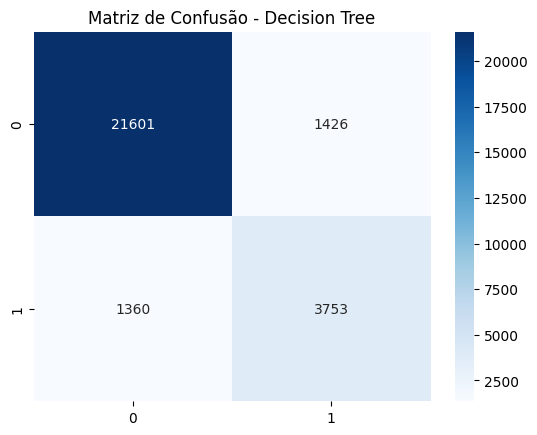

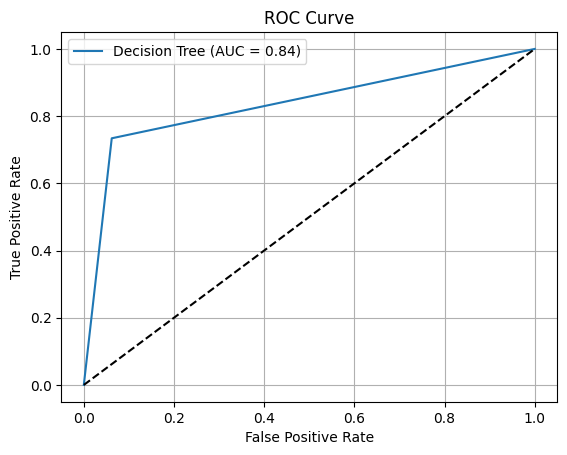


k-Nearest Neighbors
Accuracy: 0.8858564321250888
Precision: 0.7520551577830814
Recall: 0.5546645804811265
F1 Score: 0.6384511481314723
Tempo Treino: 0.0373s | Tempo Teste: 4.9431s


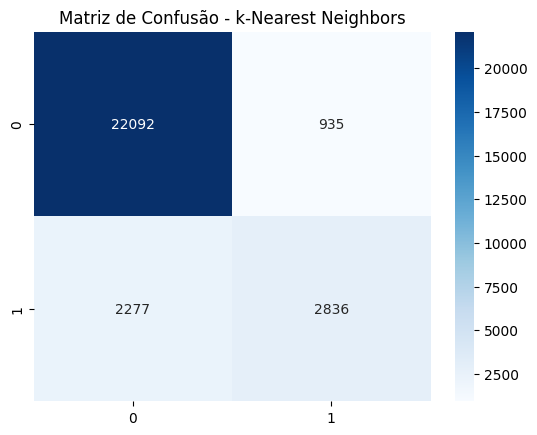

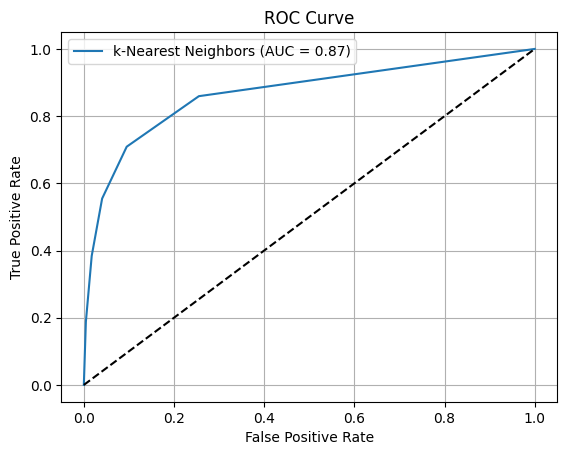

In [ ]:
acc_f1_scores = {}

acc_f1_scores['Decision Tree'] = avaliar_modelo(DecisionTreeClassifier(random_state=42), "Decision Tree")
acc_f1_scores['k-NN'] = avaliar_modelo(KNeighborsClassifier(n_neighbors=5), "k-Nearest Neighbors")
acc_f1_scores['SVM'] = avaliar_modelo(SVC(kernel='rbf', probability=True, random_state=42), "Support Vector Machine")

In [ ]:
resultados = pd.DataFrame(acc_f1_scores, index=['Accuracy', 'F1 Score']).T
resultados.plot(kind='bar', figsize=(8,5))
plt.title("Comparativo de Modelos")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.grid()
plt.show()

NameError: name 'pd' is not defined

In [ ]:
best_model = DecisionTreeClassifier(random_state=42)
train_sizes, train_scores, val_scores = learning_curve(best_model, X, y, cv=5, scoring='accuracy')
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, label="Training")
plt.plot(train_sizes, val_mean, label="Validation")
plt.title("Learning Curve - Decision Tree")
plt.xlabel("Tamanho do treino")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

## 3. Encoding das Variáveis Categóricas

In [ ]:
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])
    label_encoders[col] = le

## 4. Normalização das Variáveis Numéricas

In [ ]:
    scaler = StandardScaler()
    train_data[numeric_cols] = scaler.fit_transform(train_data[numeric_cols])

## 5. Separação em Conjunto de Treino e Teste

In [ ]:
X = train_data.drop(columns=['Depression', 'id'])
y = train_data['Depression']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Tamanho do treino: {X_train.shape}")
print(f"Tamanho do teste: {X_test.shape}")

Tamanho do treino: (112560, 18)
Tamanho do teste: (28140, 18)


## 6. Treino e Avaliação de Modelos

**Aqui vamos treinar os três modelos: Decision Tree, k-NN e SVM.**

### 6.1 Treino e Avaliação da Decision Tree


Accuracy: 0.8994314143567875
Precision: 0.719139950086389
Recall: 0.7326422843731665
F1 Score: 0.7258283278434412


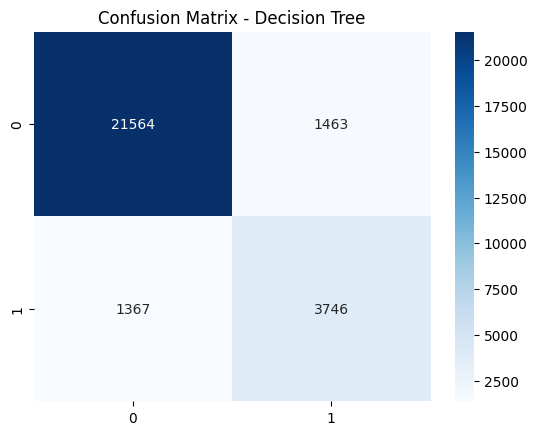

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Inicializar e treinar
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Previsões
y_pred = dt_model.predict(X_test)

# Avaliação
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Decision Tree")
plt.show()

### 6.2 Treino e Avaliação do k-Nearest Neighbors (k-NN)


k-NN Results
Accuracy: 0.8340085287846482
Precision: 0.5818518518518518
Recall: 0.3072560140817524
F1 Score: 0.4021502623832075


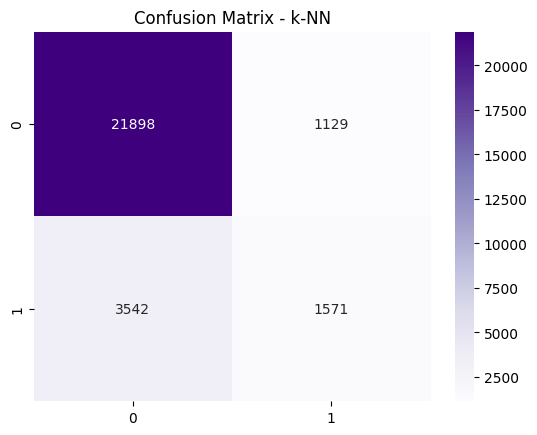

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Inicializar e treinar
knn_model = KNeighborsClassifier(n_neighbors=5)  # podes depois ajustar o k
knn_model.fit(X_train, y_train)

# Previsões
y_pred_knn = knn_model.predict(X_test)

# Avaliação
print("k-NN Results")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Precision:", precision_score(y_test, y_pred_knn))
print("Recall:", recall_score(y_test, y_pred_knn))
print("F1 Score:", f1_score(y_test, y_pred_knn))

# Matriz de Confusão
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix - k-NN")
plt.show()


### 6.3 Treino e Avaliação do Support Vector Machine (SVM)


In [ ]:
from sklearn.svm import SVC

# Inicializar e treinar
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train, y_train)

# Previsões
y_pred_svm = svm_model.predict(X_test)

# Avaliação
print("SVM Results")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Precision:", precision_score(y_test, y_pred_svm))
print("Recall:", recall_score(y_test, y_pred_svm))
print("F1 Score:", f1_score(y_test, y_pred_svm))

# Matriz de Confusão
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix - SVM")
plt.show()


KeyboardInterrupt: 

### 6.4 Comparação dos 3 Modelos (Gráfico)

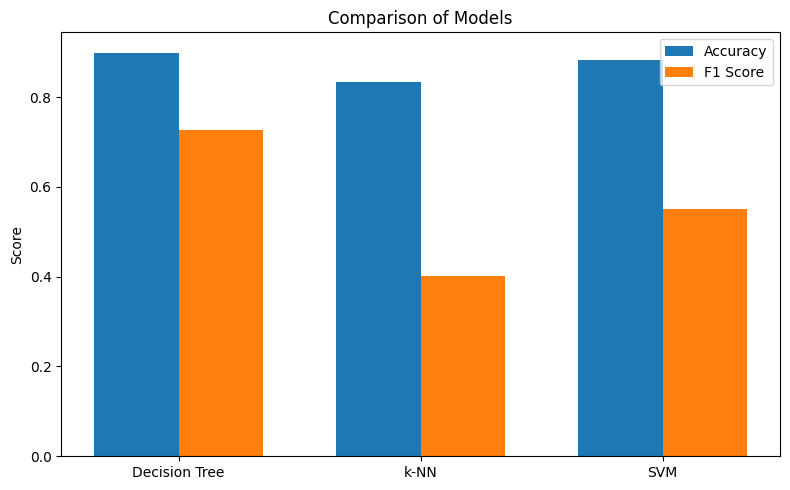

In [ ]:
# Guardar as métricas em listas
models = ['Decision Tree', 'k-NN', 'SVM']
accuracies = [
    accuracy_score(y_test, y_pred),      # Decision Tree (y_pred já treinado antes)
    accuracy_score(y_test, y_pred_knn),  # k-NN
    accuracy_score(y_test, y_pred_svm)   # SVM
]

f1_scores = [
    f1_score(y_test, y_pred),
    f1_score(y_test, y_pred_knn),
    f1_score(y_test, y_pred_svm)
]

# Gráfico de comparação
x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, accuracies, width, label='Accuracy')
rects2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score')

ax.set_ylabel('Score')
ax.set_title('Comparison of Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.tight_layout()
plt.show()
